In [167]:
import pandas as pd
import os
import requests
import numpy as np
from collections import Counter

import seaborn as sb
from matplotlib import pyplot as plt

# Import modifiers from the most recent KOLMafia build. 
mafiaMODS = requests.get('https://svn.code.sf.net/p/kolmafia/code/src/data/modifiers.txt').text

In [181]:
import warnings
warnings.simplefilter('ignore')

In [91]:
sessionDir   = '/Users/amcguire/Library/Application Support/KoLmafia/sessions'
    
# get all hookah effects

hookah = []

for file in os.listdir(sessionDir):
    
    # I use a Mac, so I have to correct for my DS store hidden files
    if file != '.DS_Store':
        
        currFile = open('{}/{}'.format(sessionDir, file)).read()

        for ct, line in enumerate(currFile.split(sep='\n')):
            if line[0:22] == 'You acquire an effect:': # Always the starting string.
                if line[-3:] == '(6)': # Hookah activations always give 6 turns.
                    hookah = hookah + [line[23:-3].strip()] # Add it to the list!
                    
print('There have been {} hookah activations in your sessions.'.format(len(hookah)))

There have been 1610 hookah activations in your sessions.


# WAYS HOOKAH EFFECTS CAN ACTUALLY SAVE TURNS, CATEGORIZED
    1. generating inigos in a free fight so you have all 5 turns of it (1 turn)
    2. the stone wool effect (depending on temple status can save a semirare or hunting for wool)
    3. meat drop effects when you're doing nuns (anywhere from <1 to 2 turns @ maximum)
    4. item drop effects when you're short on capping something (<1 turn)
    5. init for modern zmobs (1-2 turns potentially)
    6. sleaze dmg for protestor mob (very rare, but possibly saves a wish?)
    7. prismatic dmg for tavern (or just whatever your missing, saves a turn maybe); NOT COVERED
    8. sleaze res for blech house (rare and almost certainly 100% unnecessary)
    9. covetous robbery making you extremely rich early in-run
    10. +statgain flat or % effects
    11. very, very high stat increases

In [123]:
def modParse(x):
    ''' Quick custom function w/ exception for parsing modifiers from plaintext '''
    try: 
        return int(x.split('+')[1])
    except:
        return 0

def parseEffects(eff):
    ''' Function to parse through effects and generate #s according to useful in-run
        applications of hookah/horsery effects, per those examined above. I am ignoring
        Prismatic damage out of laziness; if you want to add it, just do a long 
        any-type list comp like I did for the flat/pct stats. '''
    
    meatDrop  = 0
    itemDrop  = 0
    init      = 0
    sleazeDmg = 0
    sleaseRes = 0
    poolSkill = 0
    
    famWeight = 0
    
    flatXP    = 0
    pctXP     = 0
    
    flatstat  = 0
    pctstat   = 0
    
    for x in eff:
        
        if     'Initiative'            in x: init = init + modParse(x)
        elif   'Meat Drop'             in x: meatDrop = meatDrop + modParse(x)
        elif   'Item Drop'             in x: itemDrop = itemDrop + modParse(x)
        elif   'Sleaze Damage'         in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Spell Damage'   in x: sleazeDmg = sleazeDmg + modParse(x)
        elif   'Sleaze Resistance'     in x: sleaseRes = sleaseRes + modParse(x)
        elif   'Pool Skill'            in x: poolSkill = poolSkill + modParse(x)
            
        elif   'Familiar Weight'       in x: famWeight = famWeight + modParse(x)
        
        elif   'Experience Percent'    in x: pctXP = pctXP + modParse(x)
        elif   'Experience (Familiar)' in x: flatXP = flatXP + 0
        elif   'Experience'            in x: flatXP = flatXP + modParse(x)
        
        elif any(y in x for y in ['Moxie Percent','Mysticality Percent','Muscle Percent']): 
            pctstat = pctstat + modParse(x) 
        elif any(y in x for y in ['Moxie','Mysticality','Muscle']): 
            flatstat = flatstat + modParse(x)
    
    effDict = {'meat':meatDrop, 'item':itemDrop,'init':init, 'sleazeDmg':sleazeDmg, 
               'sleazeRes':sleaseRes, 'poolSkill':poolSkill, 'famWeight':famWeight,
               'flatXP':flatXP,'pctXP':pctXP,'flatStats':flatstat,'pctStat':pctstat}
    
    return effDict

# test it w/ wolf form, which should have 150 mus% and 150 meatdrop
parseEffects(modsDF.loc[modsDF['NAME']=='Wolf Form',['EFFECTS']].values[0][0])

{'meat': 150,
 'item': 0,
 'init': 0,
 'sleazeDmg': 0,
 'sleazeRes': 0,
 'poolSkill': 0,
 'famWeight': 0,
 'flatXP': 0,
 'pctXP': 0,
 'flatStats': 0,
 'pctStat': 150}

In [109]:
modsDF.loc[modsDF['NAME']=='Stone-Faced',]

,EFFECTS,NAME,TYPE,hookah
5147,[Damage Reduction: 3],Stone-Faced,Effect,2


In [124]:
def parseRawMods(txt):
    ''' Parsing out what the effects actually do. Generates a dictionary. '''
    if txt == '': # Remove blank rows.
        return ''
    elif txt[0] == '#': # Remove comments.
        return ''
    elif txt == '3': # Remove the weird extraneous "3" that starts the file
        return ''
    elif '\tAvatar: ' in txt: # Remove avatar potions.
        return
    
    effType = txt.split('\t')[0]
    effName = txt.split('\t')[1]
    effects = txt.split('\t')[2].split(',')
    effDict = parseEffects(effects)
    
    return {'NAME':effName,'TYPE':effType,'EFFECTSLIST':effects, **effDict}
    
modsList = list(filter(None, [parseRawMods(x) for x in mafiaMODS.split('\n')]))
modsDF = pd.DataFrame(modsList)

In [126]:
# testing to make sure the effects are properly generating

for x in hookah[5:10]:
    print('{} gives the effects: {}'.format(x, modsDF.loc[modsDF['NAME']==x,'EFFECTSLIST'].values))

The Halls of Moxiousness gives the effects: [list(['Experience (Moxie): +3'])]
Always be Collecting gives the effects: [list(['Item Drop: +50', ' Meat Drop: +100'])]
The Wisdom... of the Future gives the effects: [list(['Mysticality Percent: +50', ' Mysticality: +15', ' Experience (Mysticality): +3'])]
Spiky Hair gives the effects: [list(['Muscle: +6', ' Moxie: +6'])]
Cruisin' for a Bruisin' gives the effects: [list(['Weapon Damage Percent: +100'])]


In [127]:
# Use an efficient counter function to figure out how many activations each respective skill had
countHookah = Counter(hookah)
modsDF['hookah'] = [countHookah[x] for x in modsDF.NAME]

# When sorting by activations, noticed that Sugar Rush & the general 
#   store effects were high up. This makes some sense, as those can 
#   be generated in multiples of 3. Will floor these to 2 on the 
#   assumption mafia is incorrectly categorizing them.

print(modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(5))

for effect in ['Sugar Rush', "Go Get 'Em, Tiger!", "Glittering Eyelashes", "Butt-Rock Hair"]:
    modsDF.loc[modsDF['NAME'] == effect,['hookah']] = 2

modsDF.loc[:,['NAME','hookah']].sort_values(by=['hookah'],ascending=False).head(10)

                            NAME  hookah
5167                  Sugar Rush      16
4251          Go Get 'Em, Tiger!      14
4245        Glittering Eyelashes      10
3669                Astral Shell       8
5409  Weapon of Mass Destruction       8


,NAME,hookah
3669,Astral Shell,8
5409,Weapon of Mass Destruction,8
3900,Cinnamouth,5
4282,Grrrrrrreat!,5
4691,Neuroplastici Tea,5
5465,You Can Really Taste the Dormouse,5
4990,Shortened,5
4523,L'instinct F&eacute;lin,5
3824,Bugbear in Tooth and Claw,5
4036,Down With Chow,4


In [130]:
# Looking at effects that do not appear to be hookah-activated, we see a 
#   lot of ML & "negative" effects; this fits our intuition. That said, 
#   there are a few here that are probably actually eligible.

modsDF.loc[(modsDF['hookah']==0) & (modsDF['TYPE'] == 'Effect'),['EFFECTSLIST','NAME']].head()

,EFFECTSLIST,NAME
3578,[Moxie: -5],&quot;The Disease&quot;
3580,"[Muscle: +6, Moxie: -3]",1337p4n7Z
3581,"[Experience: +3, Experience (familiar): +3]","2 Hearts, 1 Mind"
3587,"[Familiar Weight: +5, Experience (familiar): ...",A Girl Named Sue
3588,[Monster Level: +2],[597]A Little Bit Evil


In [186]:
# Effects that are useful in and of themselves:

usefulEffects = ['Stone-Faced', 'Craft Tea', "Inigo's Incantation of Inspiration", "Covetous Robbery","Dirty Pear"]

for eff in usefulEffects:
    print('{} occurred in {} of {} activations, a rate of {:.2%}.'.format(eff,countHookah[eff],len(hookah),countHookah[eff]/len(hookah)))

Stone-Faced occurred in 2 of 1610 activations, a rate of 0.12%.
Craft Tea occurred in 1 of 1610 activations, a rate of 0.06%.
Inigo's Incantation of Inspiration occurred in 2 of 1610 activations, a rate of 0.12%.
Covetous Robbery occurred in 1 of 1610 activations, a rate of 0.06%.
Dirty Pear occurred in 1 of 1610 activations, a rate of 0.06%.


In [193]:
def summarizeField(df, fName, c='g', lowBound=0):
    ''' Summarization function for individual fields. '''
    
    # Filter down to only effects w/ hookah activations & relevant column for summarization
    df = df.loc[df['hookah']>0,[fName,'hookah']]
    
    allActivations = sum(df['hookah'])
    
    # Cut out non-relevant activations now that we know the #
    df = df.loc[df[fName]>lowBound,:]
    
    print('For {}, there were {} relevant activations out of {}, a rate of {:.2%}.\n'.format(fName,sum(df['hookah']),allActivations,sum(df['hookah'])/allActivations))
    
    allAvg = sum(df[fName]*df['hookah'])/allActivations
    popAvg = sum(df[fName]*df['hookah'])/sum(df['hookah'])
    print('  Average per activation:    +{:0.5}'.format(allAvg))
    print('  Average when activated:    +{:0.5}\n'.format(popAvg))
    print('  Maximum buff:              +{}, {} times\n'.format(max(df[fName].values),sum(df.loc[df[fName]==max(df[fName]),['hookah']].values[0])))
    
    # Generate a nice histogram of the distribution of activation buffs assuming equal activations
    fig, ax = plt.subplots()
    sb.distplot(df[fName],kde = False, color=c,ax=ax)
    ax.set(ylabel="# of Activations") 
    sb.set_style("dark")
    sb.despine()
    plt.show()
    

For init, there were 105 relevant activations out of 1491, a rate of 7.04%.

  Average per activation:    +3.7344
  Average when activated:    +53.029

  Maximum buff:              +300, 1 times



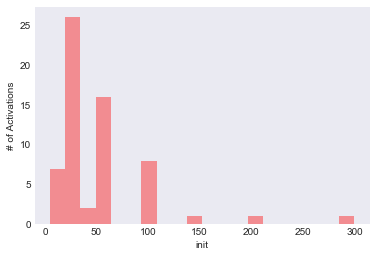

For meat, there were 73 relevant activations out of 1491, a rate of 4.90%.

  Average per activation:    +2.2669
  Average when activated:    +46.301

  Maximum buff:              +200, 1 times



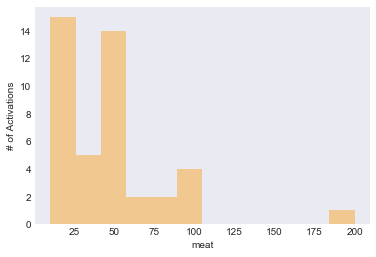

For item, there were 86 relevant activations out of 1491, a rate of 5.77%.

  Average per activation:    +1.4004
  Average when activated:    +24.279

  Maximum buff:              +100, 1 times



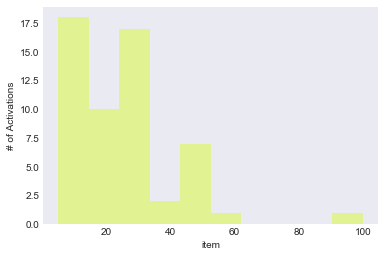

For sleazeDmg, there were 48 relevant activations out of 1491, a rate of 3.22%.

  Average per activation:    +0.85312
  Average when activated:    +26.5

  Maximum buff:              +100, 1 times



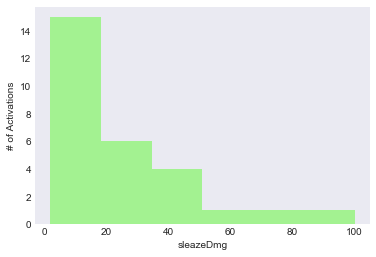

For sleazeRes, there were 49 relevant activations out of 1491, a rate of 3.29%.

  Average per activation:    +0.073105
  Average when activated:    +2.2245

  Maximum buff:              +9, 1 times



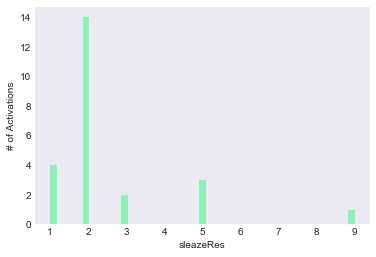

For poolSkill, there were 6 relevant activations out of 1491, a rate of 0.40%.

  Average per activation:    +0.013414
  Average when activated:    +3.3333

  Maximum buff:              +5, 1 times



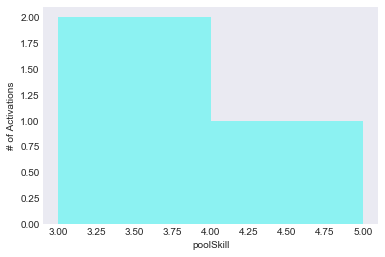

For famWeight, there were 52 relevant activations out of 1491, a rate of 3.49%.

  Average per activation:    +0.20657
  Average when activated:    +5.9231

  Maximum buff:              +10, 2 times



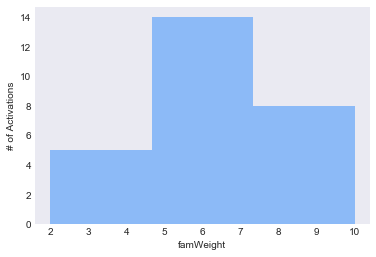

For flatXP, there were 96 relevant activations out of 1491, a rate of 6.44%.

  Average per activation:    +0.24279
  Average when activated:    +3.7708

  Maximum buff:              +12, 1 times



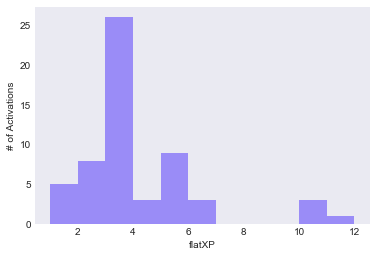

For pctXP, there were 12 relevant activations out of 1491, a rate of 0.80%.

  Average per activation:    +0.11066
  Average when activated:    +13.75

  Maximum buff:              +25, 2 times



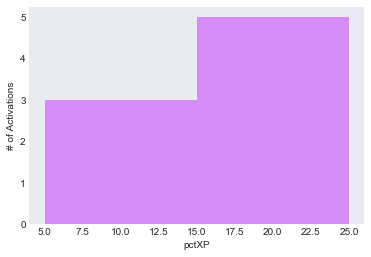

For flatStats, there were 202 relevant activations out of 1491, a rate of 13.55%.

  Average per activation:    +3.1791
  Average when activated:    +23.465

  Maximum buff:              +120, 2 times



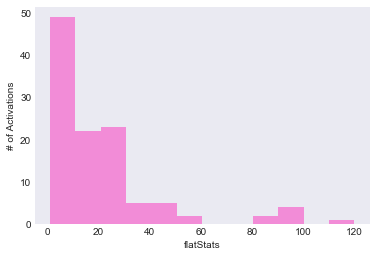

For pctStat, there were 269 relevant activations out of 1491, a rate of 18.04%.

  Average per activation:    +14.738
  Average when activated:    +81.688

  Maximum buff:              +600, 2 times



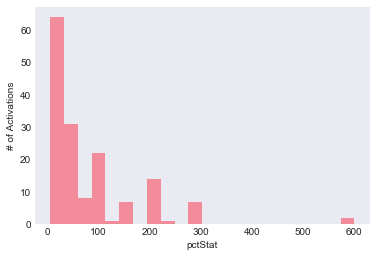

In [194]:
buffsAnalyzed = ['init','meat','item','sleazeDmg','sleazeRes','poolSkill',
                 'famWeight','flatXP','pctXP','flatStats','pctStat']

cmap = plt.cm.get_cmap('hsv',len(buffsAnalyzed))

for i, x in enumerate(buffsAnalyzed):
    summarizeField(modsDF, x, c=cmap(i))